# JCC2 Questionnaire Master Analysis Notebook

This comprehensive notebook analyzes JCC2 User Questionnaire data across multiple dimensions:
- Application-Section effectiveness ratings
- User demographics and role analysis
- Sentiment analysis of qualitative feedback
- System usability and suitability evaluation
- Training and support effectiveness
- Comparative analysis across DCDC, CNMF, and COGUARD datasets

**Analysis Date**: import datetime; datetime.datetime.now().strftime('%Y-%m-%d')
**Datasets**: DCDC, CNMF, COGUARD User Questionnaires

## Table of Contents

1. [Setup and Data Loading](#setup)
2. [Application-Section Matrix Analysis](#app-section)
3. [User Demographics Analysis](#demographics)
4. [Sentiment Analysis of Feedback](#sentiment)
5. [System Usability and Suitability Analysis](#usability)
6. [Training and Support Effectiveness](#training)
7. [Comparative Analysis Across Datasets](#comparative)
8. [Key Insights and Recommendations](#insights)

## 1. Setup and Data Loading <a id='setup'></a>

In [1]:
# System setup
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

# Import the processor module
from jcc2_data_processor import create_processor

# Data manipulation and analysis
import pandas as pd
import numpy as np
from datetime import datetime
import json
import re
from collections import Counter, defaultdict

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Professional tables
from great_tables import GT, md, html, loc, style

# Text analysis
from textblob import TextBlob
from wordcloud import WordCloud

# Statistical analysis
from scipy import stats
from scipy.stats import chi2_contingency, f_oneway

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Configure visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Define consistent color scheme
COLORS = {
    'primary': '#1f77b4',
    'secondary': '#ff7f0e',
    'tertiary': '#9467bd',
    'success': '#2ca02c',
    'danger': '#d62728',
    'warning': '#ff9800',
    'info': '#17a2b8',
    'gray': '#7f7f7f'
}

# Create output directory
output_dir = 'jcc2_master_analysis_output'
os.makedirs(output_dir, exist_ok=True)

print(f"Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Output directory: {output_dir}")

Analysis started at: 2025-08-03 18:02:19
Output directory: jcc2_master_analysis_output


In [2]:
# Load all datasets
data_files = {
  "DCDC": "/home/nathanjgaul/Development/projects/form_manager/data_analysis/data/real_world_data/DCDC UQ Combined_2025-07-30_pii_scrubbed.csv",
  "CNMF": "/home/nathanjgaul/Development/projects/form_manager/data_analysis/data/real_world_data/CNMF UQ Combined_2025-08-03_pii_scrubbed.csv",
  "COGUARD": "/home/nathanjgaul/Development/projects/form_manager/data_analysis/data/real_world_data/GOGUARD UQ Combined_2025-08-03_pii_scrubbed.csv"
}

# Initialize processors and dataframes
processors = {}
dataframes = {}
dataset_info = {}

for name, filepath in data_files.items():
    try:
        processors[name] = create_processor(filepath)
        dataframes[name] = processors[name].load_data()
        
        # Store dataset info
        dataset_info[name] = {
            'responses': len(dataframes[name]),
            'fields': len(dataframes[name].columns),
            'sections': len(processors[name].sections),
            'date_range': f"{dataframes[name]['user_information.date'].min()} to {dataframes[name]['user_information.date'].max()}"
            if 'user_information.date' in dataframes[name].columns else 'N/A'
        }
        
        print(f"\n{name} Dataset:")
        print(f"  - Responses: {dataset_info[name]['responses']}")
        print(f"  - Fields: {dataset_info[name]['fields']}")
        print(f"  - Sections: {dataset_info[name]['sections']}")
        print(f"  - Date range: {dataset_info[name]['date_range']}")
        
    except Exception as e:
        print(f"\nError loading {name}: {e}")

# Create combined dataset for collective analysis
combined_df = pd.concat(dataframes.values(), ignore_index=True)
print(f"\nCombined Dataset:")
print(f"  - Total Responses: {len(combined_df)}")
print(f"  - Total Fields: {len(combined_df.columns)}")

2025-08-03 18:02:20,033 - INFO - Detected User Questionnaire format
2025-08-03 18:02:20,034 - INFO - Loading data from /home/nathanjgaul/Development/projects/form_manager/data_analysis/data/real_world_data/DCDC UQ Combined_2025-07-30_pii_scrubbed.csv
2025-08-03 18:02:20,046 - INFO - Parsing field schemas
2025-08-03 18:02:20,054 - INFO - Loaded 21 data rows with 667 columns
2025-08-03 18:02:20,055 - INFO - Found 28 sections and 6 system columns
2025-08-03 18:02:20,082 - INFO - Detected User Questionnaire format
2025-08-03 18:02:20,083 - INFO - Loading data from /home/nathanjgaul/Development/projects/form_manager/data_analysis/data/real_world_data/CNMF UQ Combined_2025-08-03_pii_scrubbed.csv
2025-08-03 18:02:20,094 - INFO - Parsing field schemas
2025-08-03 18:02:20,102 - INFO - Loaded 6 data rows with 667 columns
2025-08-03 18:02:20,103 - INFO - Found 28 sections and 6 system columns
2025-08-03 18:02:20,128 - INFO - Detected User Questionnaire format
2025-08-03 18:02:20,129 - INFO - Load


DCDC Dataset:
  - Responses: 21
  - Fields: 667
  - Sections: 28
  - Date range: 2025-06-23 to 2025-06-25

CNMF Dataset:
  - Responses: 6
  - Fields: 667
  - Sections: 28
  - Date range: 2025-06-26 to 2025-06-26

COGUARD Dataset:
  - Responses: 6
  - Fields: 667
  - Sections: 28
  - Date range: 2025-06-30 to 2025-06-30

Combined Dataset:
  - Total Responses: 33
  - Total Fields: 667


### Helper Functions

In [3]:
# Rating mappings and helper functions
rating_map = {
    'Completely Ineffective': 1,
    'Moderately Ineffective': 2,
    'Slightly Ineffective': 3,
    'Slightly Effective': 4,
    'Moderately Effective': 5,
    'Completely Effective': 6
}

# Agreement scale mapping
agreement_map = {
    'Strongly Disagree': 1,
    'Disagree': 2,
    'Somewhat Disagree': 3,
    'Somewhat Agree': 4,
    'Agree': 5,
    'Strongly Agree': 6
}

def calculate_rating_stats(series, mapping=rating_map):
    """Calculate statistics for a rating field"""
    valid_values = series.dropna()[~series.isin(['NA', 'N/A', 'Not Applicable'])]
    if len(valid_values) == 0:
        return None
    
    numeric_values = valid_values.map(mapping).dropna()
    if len(numeric_values) == 0:
        return None
    
    return {
        'mean': numeric_values.mean(),
        'median': numeric_values.median(),
        'std': numeric_values.std(),
        'min': numeric_values.min(),
        'max': numeric_values.max(),
        'count': len(numeric_values),
        'na_count': (series == 'Not Applicable').sum()
    }

def create_rating_distribution_plot(series, title, mapping=rating_map, figsize=(10, 6)):
    """Create a distribution plot for rating data"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Count plot
    value_counts = series.value_counts()
    order = ['Completely Ineffective', 'Moderately Ineffective', 'Slightly Ineffective',
             'Slightly Effective', 'Moderately Effective', 'Completely Effective', 'Not Applicable']
    order = [x for x in order if x in value_counts.index]
    
    value_counts.reindex(order, fill_value=0).plot(kind='bar', ax=ax1, color=COLORS['primary'])
    ax1.set_title(f'{title} - Response Distribution')
    ax1.set_xlabel('Rating')
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=45)
    
    # Pie chart
    ax2.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
    ax2.set_title(f'{title} - Response Percentage')
    
    plt.tight_layout()
    return fig

def export_to_excel(filename, sheets_dict):
    """Export multiple dataframes to Excel with formatting"""
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        for sheet_name, df in sheets_dict.items():
            df.to_excel(writer, sheet_name=sheet_name[:31], index=True)  # Excel sheet names limited to 31 chars
    print(f"Exported to: {filename}")

## 2. Application-Section Matrix Analysis <a id='app-section'></a>

This section replicates and extends the application-section effectiveness rating analysis from the base notebook.

In [4]:
# Define sections and applications (from base notebook)
target_sections = [
    'mop_1_1_1', 'mos_1_1_2', 'mop_1_1_3', 'reporting_and_data_export',
    'mop_1_1_5', 'mop_1_2_1', 'mop_1_2_2', 'mos_1_3_1',
    'mop_1_3_2', 'mop_1_3_3', 'mop_1_3_4', 'mop_1_3_5',
    'mop_2_1_1', 'mop_2_1_2', 'mop_2_1_7', 'mop_2_1_9',
    'mop_2_3_1', 'mop_2_3_2', 'mop_2_4_1', 'mos_3_2_1',
    'mos_3_2_2', 'mop_3_2_3'
]

all_applications = [
    'a2it', 'cad', 'codex', 'crucible', 'cyber9line', 'dispatch',
    'jcc2cyberops', 'jcc2readiness', 'madss', 'rally', 'redmap',
    'sigact', 'threathub', 'triage', 'unity'
]

# Display names
app_display_names = {
    'a2it': 'A2IT', 'cad': 'CAD', 'codex': 'Codex',
    'crucible': 'Crucible', 'cyber9line': 'Cyber 9-Line',
    'dispatch': 'Dispatch', 'jcc2cyberops': 'JCC2 Cyber Ops',
    'jcc2readiness': 'JCC2 Readiness', 'madss': 'MADSS',
    'rally': 'Rally', 'redmap': 'REDMAP', 'sigact': 'SigAct',
    'threathub': 'Threat Hub', 'triage': 'Triage', 'unity': 'Unity'
}

section_display_names = {
    'mop_1_1_1': 'MOP 1.1.1', 'mos_1_1_2': 'MOS 1.1.2',
    'mop_1_1_3': 'MOP 1.1.3', 'reporting_and_data_export': 'Reporting & Export',
    'mop_1_1_5': 'MOP 1.1.5', 'mop_1_2_1': 'MOP 1.2.1',
    'mop_1_2_2': 'MOP 1.2.2', 'mos_1_3_1': 'MOS 1.3.1',
    'mop_1_3_2': 'MOP 1.3.2', 'mop_1_3_3': 'MOP 1.3.3',
    'mop_1_3_4': 'MOP 1.3.4', 'mop_1_3_5': 'MOP 1.3.5',
    'mop_2_1_1': 'MOP 2.1.1', 'mop_2_1_2': 'MOP 2.1.2',
    'mop_2_1_7': 'MOP 2.1.7', 'mop_2_1_9': 'MOP 2.1.9',
    'mop_2_3_1': 'MOP 2.3.1', 'mop_2_3_2': 'MOP 2.3.2',
    'mop_2_4_1': 'MOP 2.4.1', 'mos_3_2_1': 'MOS 3.2.1',
    'mos_3_2_2': 'MOS 3.2.2', 'mop_3_2_3': 'MOP 3.2.3'
}

In [14]:
# Helper function to check for rating fields
def normalize_for_comparison(lst):
    """Convert list to set, treating all NaN types as equivalent"""
    result = set()
    for item in lst:
        if pd.isna(item):
            result.add('__NaN__')
        else:
            result.add(item)
    return result

# Define standard rating values
rating_values = [
    'Completely Ineffective',
    'Moderately Ineffective',
    'Slightly Ineffective',
    'Slightly Effective',
    'Moderately Effective',
    'Completely Effective',
    'Not Applicable',
    float('nan'),
    np.nan
]

normalized_rating_set = normalize_for_comparison(rating_values)

In [15]:
# Import matrix generation functions from base notebook logic
# (These functions are simplified versions of the base notebook functions)

def get_app_from_field(field_name, section_prefix=""):
    """Extract app name from field"""
    if section_prefix and field_name.startswith(section_prefix):
        field_without_section = field_name[len(section_prefix):].lstrip(".")
    else:
        field_without_section = field_name
    
    for app in all_applications:
        if (field_without_section.endswith(app) or 
            field_without_section.endswith(f"_{app}") or
            field_without_section.endswith(f"-{app}")):
            return app
    return None

def calculate_field_rating(field_name, df):
    """Calculate average rating for a field"""
    if field_name not in df.columns:
        return None, 0, 0
    
    values = df[field_name]
    na_count = values.isin(['NA', 'N/A', 'Not Applicable']).sum()
    valid_mask = values.notna() & ~values.isin(['NA', 'N/A', 'Not Applicable'])
    valid_values = values[valid_mask]
    
    if len(valid_values) == 0:
        return None, na_count, len(values) - values.isna().sum()
    
    numeric_values = valid_values.map(rating_map).dropna()
    if len(numeric_values) == 0:
        return None, na_count, len(values) - values.isna().sum()
    
    return numeric_values.mean(), na_count, len(values) - values.isna().sum()

def create_rating_matrix(df, processor, dataset_name="Dataset"):
    """Create a rating matrix for a specific dataset"""
    
    print(f"\nCreating matrix for: {dataset_name}")
    print("=" * 80)
    
    # First, analyze sections for this dataset
    section_field_analysis = {}
    
    for section in target_sections:
        if section in processor.sections:
            fields = processor.sections[section]
            field_analysis = {
                "total_fields": len(fields),
                "app_specific_fields": {},
                "overall_fields": [],
            }

            # Identify rating fields
            rating_fields = [
                field
                for field in fields
                if not df[field].apply(lambda x: isinstance(x, list)).any()
                and not normalize_for_comparison(df[field].unique()) - normalized_rating_set
            ]

            for field in rating_fields:
                app_found = False
                field_lower = field.lower()
                
                # Check for app-specific field
                detected_app = get_app_from_field(field, section_prefix=f"{section}")
                if detected_app:
                    if detected_app not in field_analysis["app_specific_fields"]:
                        field_analysis["app_specific_fields"][detected_app] = []
                    field_analysis["app_specific_fields"][detected_app].append(field)
                    app_found = True
                elif field == "mop_2_4_1.mission_progress_assessment":
                    detected_app = "jcc2cyberops"
                    if detected_app not in field_analysis["app_specific_fields"]:
                        field_analysis["app_specific_fields"][detected_app] = []
                    field_analysis["app_specific_fields"][detected_app].append(field)
                    app_found = True

                # If not app-specific, it's likely an overall field
                if not app_found:
                    if "overall" in field_lower:
                        field_analysis["overall_fields"].append(field)
                    else:
                        field_analysis["overall_fields"].append(field)

            section_field_analysis[section] = field_analysis
    
    # Create the rating matrix
    matrix_data = []
    row_labels = []

    # Process each application
    for app in all_applications:
        row_data = []
        row_labels.append(app_display_names.get(app, app))
        
        for section in target_sections:
            if section not in section_field_analysis:
                row_data.append('x')
                continue

            # Check if this app has fields in this section
            app_fields = section_field_analysis[section]['app_specific_fields'].get(app, [])
            
            if not app_fields:
                row_data.append('x')
            else:
                # Calculate average rating for all app-specific fields
                ratings = []
                total_responses = 0
                na_responses = 0
                
                for field in app_fields:
                    rating, na_count, total_count = calculate_field_rating(field, df)
                    if rating is not None:
                        ratings.append(rating)
                    total_responses += total_count
                    na_responses += na_count
                
                if ratings:
                    avg_rating = np.mean(ratings)
                    row_data.append(f"{avg_rating:.1f}")
                elif na_responses > 0 and na_responses == total_responses:
                    row_data.append('N/A')
                else:
                    row_data.append('*')
        
        matrix_data.append(row_data)
    
    # Create DataFrame
    column_labels = [section_display_names.get(s, s) for s in target_sections]
    matrix_df = pd.DataFrame(matrix_data, index=row_labels, columns=column_labels)
    
    return matrix_df, matrix_data, row_labels, column_labels

In [16]:
# Generate matrices for all datasets
print("Generating Application-Section Matrices...\n")

all_matrices = {}
matrix_stats = {}

for dataset_name, df in dataframes.items():
    processor = processors[dataset_name]
    matrix_df, matrix_data, row_labels, column_labels = create_rating_matrix(df, processor, dataset_name)
    all_matrices[dataset_name] = matrix_df
    
    # Calculate statistics
    ratings = []
    for row in matrix_data:
        for val in row:
            try:
                ratings.append(float(val))
            except:
                pass

    if ratings:
        matrix_stats[dataset_name] = {
            'mean': np.mean(ratings),
            'std': np.std(ratings),
            'median': np.median(ratings),
            'min': min(ratings),
            'max': max(ratings)
        }
    
    print(f"{dataset_name} Matrix Generated:")
    print(f"  - Mean Rating: {matrix_stats[dataset_name]['mean']:.2f}")
    print(f"  - Std Dev: {matrix_stats[dataset_name]['std']:.2f}")
    print(f"  - Range: {matrix_stats[dataset_name]['min']:.1f} - {matrix_stats[dataset_name]['max']:.1f}\n")

Generating Application-Section Matrices...


Creating matrix for: DCDC
DCDC Matrix Generated:
  - Mean Rating: 3.34
  - Std Dev: 0.92
  - Range: 1.0 - 5.5


Creating matrix for: CNMF
CNMF Matrix Generated:
  - Mean Rating: 4.66
  - Std Dev: 0.75
  - Range: 3.2 - 5.5


Creating matrix for: COGUARD
COGUARD Matrix Generated:
  - Mean Rating: 5.05
  - Std Dev: 0.62
  - Range: 3.0 - 6.0



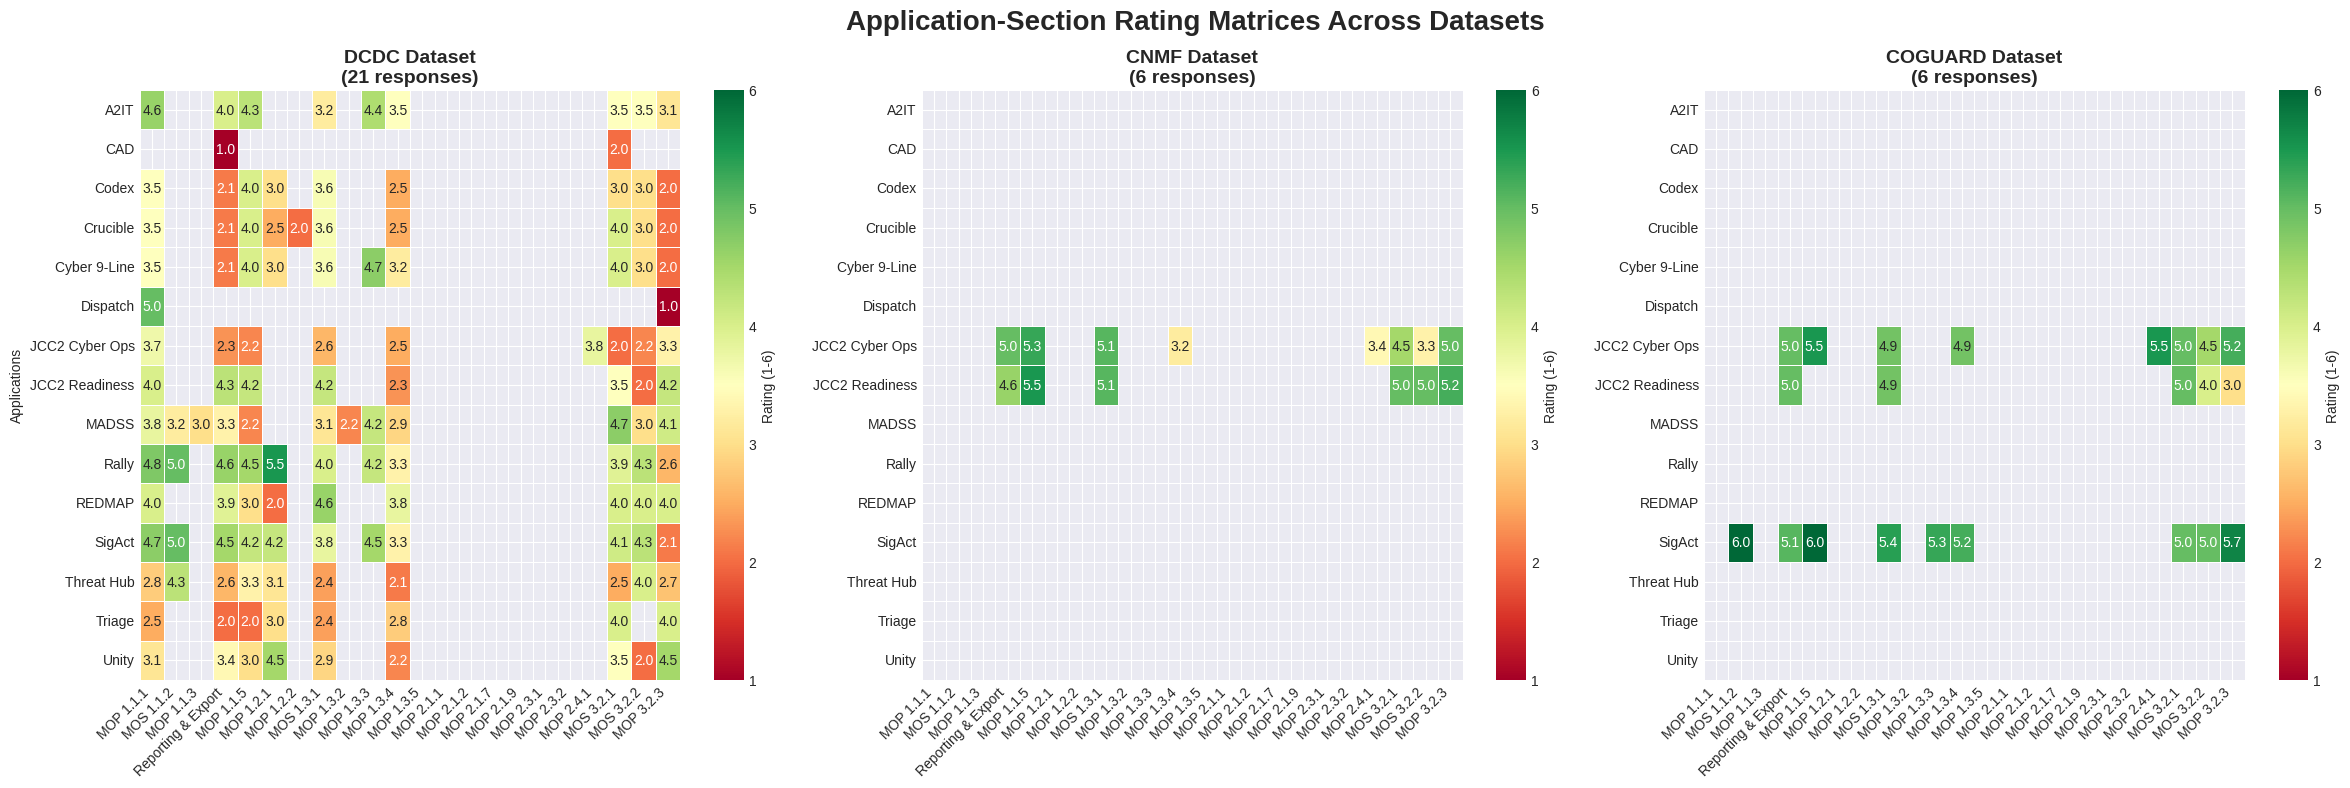

In [18]:
# Create comparative visualization
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('Application-Section Rating Matrices Across Datasets', fontsize=20, fontweight='bold')

for idx, (dataset_name, matrix_df) in enumerate(all_matrices.items()):
    ax = axes[idx]
    
    # Convert to numeric for heatmap
    numeric_matrix = matrix_df.copy()
    for col in numeric_matrix.columns:
        numeric_matrix[col] = pd.to_numeric(numeric_matrix[col], errors='coerce')
    
    # Create heatmap
    sns.heatmap(numeric_matrix, annot=matrix_df.values, fmt='', 
                cmap='RdYlGn', vmin=1, vmax=6, 
                cbar_kws={'label': 'Rating (1-6)'}, 
                ax=ax, linewidths=0.5)
    
    ax.set_title(f'{dataset_name} Dataset\n({dataset_info[dataset_name]["responses"]} responses)', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Applications' if idx == 0 else '')
    
    # Rotate labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.savefig(f'{output_dir}/application_section_matrices_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. User Demographics Analysis <a id='demographics'></a>

Analyzing user roles, experience levels, and their correlation with effectiveness ratings.

In [19]:
# Identify demographic fields
demographic_fields = {
    'role': 'basic_information.status_of_current_role',
    'cyber_operator': 'basic_information.current_cyber_operator',
    'echelon': 'basic_information.echelon',
    'duties': 'basic_information.duties_in_role',
    'experience': 'basic_information.relevant_experience'
}

# Function to analyze demographics for a dataset
def analyze_demographics(df, dataset_name):
    """Analyze demographic distribution for a dataset"""
    print(f"\n{'='*60}")
    print(f"Demographics Analysis: {dataset_name}")
    print(f"{'='*60}")
    
    demographics_data = {}
    
    for demo_name, field in demographic_fields.items():
        if field in df.columns:
            # Get value counts
            value_counts = df[field].value_counts(dropna=False)
            demographics_data[demo_name] = value_counts
            
            print(f"\n{demo_name.upper()} Distribution:")
            for value, count in value_counts.items():
                percentage = (count / len(df)) * 100
                print(f"  {value}: {count} ({percentage:.1f}%)")
        else:
            print(f"\n{demo_name.upper()}: Field not found")
    
    return demographics_data

# Analyze demographics for each dataset
all_demographics = {}
for dataset_name, df in dataframes.items():
    all_demographics[dataset_name] = analyze_demographics(df, dataset_name)


Demographics Analysis: DCDC

ROLE: Field not found

CYBER_OPERATOR: Field not found

ECHELON: Field not found

DUTIES: Field not found

EXPERIENCE: Field not found

Demographics Analysis: CNMF

ROLE: Field not found

CYBER_OPERATOR: Field not found

ECHELON: Field not found

DUTIES: Field not found

EXPERIENCE: Field not found

Demographics Analysis: COGUARD

ROLE: Field not found

CYBER_OPERATOR: Field not found

ECHELON: Field not found

DUTIES: Field not found

EXPERIENCE: Field not found


In [ ]:
# Create demographic visualization dashboard
def create_demographics_dashboard(all_demographics, dataset_info):
    """Create a comprehensive demographics dashboard"""
    fig = plt.figure(figsize=(20, 12))
    fig.suptitle('User Demographics Analysis Across Datasets', fontsize=20, fontweight='bold')
    
    # Define subplot layout
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Response counts by dataset
    ax1 = fig.add_subplot(gs[0, 0])
    response_counts = [dataset_info[ds]['responses'] for ds in dataset_info]
    ax1.bar(dataset_info.keys(), response_counts, color=COLORS['primary'])
    ax1.set_title('Response Counts by Dataset', fontweight='bold')
    ax1.set_ylabel('Number of Responses')
    for i, v in enumerate(response_counts):
        ax1.text(i, v + 0.5, str(v), ha='center', va='bottom')
    
    # 2. Role distribution (combined)
    ax2 = fig.add_subplot(gs[0, 1:3])
    combined_roles = pd.Series()
    for dataset_name in all_demographics:
        if 'role' in all_demographics[dataset_name]:
            combined_roles = pd.concat([combined_roles, all_demographics[dataset_name]['role']])
    
    if not combined_roles.empty:
        role_counts = combined_roles.groupby(combined_roles).sum()
        role_counts.plot(kind='barh', ax=ax2, color=COLORS['secondary'])
        ax2.set_title('Role Distribution (All Datasets Combined)', fontweight='bold')
        ax2.set_xlabel('Count')
    
    # 3. Cyber Operator Status
    ax3 = fig.add_subplot(gs[1, 0])
    cyber_op_data = []
    labels = []
    for dataset_name in all_demographics:
        if 'cyber_operator' in all_demographics[dataset_name]:
            cyber_counts = all_demographics[dataset_name]['cyber_operator']
            # Get Yes/No counts
            yes_count = cyber_counts.get('Yes', 0)
            no_count = cyber_counts.get('No', 0)
            cyber_op_data.append([yes_count, no_count])
            labels.append(dataset_name)
    
    if cyber_op_data:
        cyber_df = pd.DataFrame(cyber_op_data, index=labels, columns=['Yes', 'No'])
        cyber_df.plot(kind='bar', ax=ax3, color=[COLORS['success'], COLORS['danger']])
        ax3.set_title('Cyber Operator Status by Dataset', fontweight='bold')
        ax3.set_ylabel('Count')
        ax3.legend(title='Cyber Operator')
        ax3.tick_params(axis='x', rotation=45)
    
    # 4. Echelon distribution
    ax4 = fig.add_subplot(gs[1, 1:3])
    echelon_counts = defaultdict(lambda: defaultdict(int))
    for dataset_name in all_demographics:
        if 'echelon' in all_demographics[dataset_name]:
            for echelon, count in all_demographics[dataset_name]['echelon'].items():
                if pd.notna(echelon):
                    echelon_counts[echelon][dataset_name] = count
    
    if echelon_counts:
        echelon_df = pd.DataFrame(echelon_counts).T.fillna(0)
        echelon_df.plot(kind='bar', ax=ax4, stacked=True)
        ax4.set_title('Echelon Distribution by Dataset', fontweight='bold')
        ax4.set_xlabel('Echelon')
        ax4.set_ylabel('Count')
        ax4.legend(title='Dataset')
        ax4.tick_params(axis='x', rotation=45)
    
    # 5. Experience distribution
    ax5 = fig.add_subplot(gs[2, :])
    # This would show experience categories if the data structure supports it
    ax5.text(0.5, 0.5, 'Experience Analysis\n(Requires multi-select field parsing)', 
             ha='center', va='center', transform=ax5.transAxes, fontsize=14)
    ax5.set_title('Experience Distribution', fontweight='bold')
    ax5.axis('off')
    
    plt.tight_layout()
    return fig

# Create and save demographics dashboard
demo_fig = create_demographics_dashboard(all_demographics, dataset_info)
demo_fig.savefig(f'{output_dir}/demographics_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Analyze correlation between demographics and ratings
def analyze_demographic_rating_correlation(df, demographic_field, rating_fields, dataset_name):
    """Analyze how demographics correlate with effectiveness ratings"""
    if demographic_field not in df.columns:
        return None
    
    # Get unique demographic values
    demo_values = df[demographic_field].dropna().unique()
    
    results = {}
    for demo_val in demo_values:
        mask = df[demographic_field] == demo_val
        subset = df[mask]
        
        ratings = []
        for field in rating_fields:
            if field in subset.columns:
                field_ratings = subset[field].map(rating_map).dropna()
                ratings.extend(field_ratings.tolist())
        
        if ratings:
            results[demo_val] = {
                'mean': np.mean(ratings),
                'std': np.std(ratings),
                'count': len(ratings),
                'n_users': len(subset)
            }
    
    return results

# Find overall effectiveness rating fields
overall_rating_fields = []
for dataset_name, processor in processors.items():
    for section, fields in processor.sections.items():
        for field in fields:
            if 'overall' in field.lower() and 'effectiveness' in field.lower():
                if field not in overall_rating_fields:
                    overall_rating_fields.append(field)

print(f"Found {len(overall_rating_fields)} overall effectiveness rating fields")

# Analyze correlations for cyber operator status
cyber_op_correlations = {}
for dataset_name, df in dataframes.items():
    correlation = analyze_demographic_rating_correlation(
        df, 
        demographic_fields['cyber_operator'],
        overall_rating_fields,
        dataset_name
    )
    if correlation:
        cyber_op_correlations[dataset_name] = correlation

# Visualize correlation results
if cyber_op_correlations:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Prepare data for plotting
    yes_means = []
    no_means = []
    labels = []
    
    for dataset, data in cyber_op_correlations.items():
        if 'Yes' in data:
            yes_means.append(data['Yes']['mean'])
        else:
            yes_means.append(0)
        
        if 'No' in data:
            no_means.append(data['No']['mean'])
        else:
            no_means.append(0)
        
        labels.append(dataset)
    
    x = np.arange(len(labels))
    width = 0.35
    
    ax.bar(x - width/2, yes_means, width, label='Cyber Operator: Yes', color=COLORS['success'])
    ax.bar(x + width/2, no_means, width, label='Cyber Operator: No', color=COLORS['danger'])
    
    ax.set_xlabel('Dataset')
    ax.set_ylabel('Average Effectiveness Rating')
    ax.set_title('Effectiveness Ratings by Cyber Operator Status')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.set_ylim(0, 6)
    
    # Add value labels
    for i in range(len(labels)):
        if yes_means[i] > 0:
            ax.text(i - width/2, yes_means[i] + 0.1, f'{yes_means[i]:.2f}', 
                    ha='center', va='bottom')
        if no_means[i] > 0:
            ax.text(i + width/2, no_means[i] + 0.1, f'{no_means[i]:.2f}', 
                    ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/cyber_operator_rating_correlation.png', dpi=300)
    plt.show()

## 4. Sentiment Analysis of Feedback <a id='sentiment'></a>

Analyzing qualitative feedback using sentiment analysis and text mining techniques.

In [ ]:
# Define text feedback fields
text_feedback_fields = {
    'workarounds': 'mop_2_4_1.workarounds_description',
    'workaround_reasons': 'mop_2_4_1.workaround_reasons',
    'training_observations': 'mos_3_2_1.additional_observations',
    'support_observations': 'mop_3_2_3.additional_observations',
    'critical_issues': 'user_evaluation_of_overall_system_suitability.critical_issues',
    'shout_outs': 'user_evaluation_of_overall_system_suitability.shout_outs',
    'final_thoughts': 'user_evaluation_of_overall_system_suitability.final_thoughts'
}

def extract_text_feedback(df, field_mapping):
    """Extract all text feedback from a dataframe"""
    feedback = {}
    
    for feedback_type, field in field_mapping.items():
        if field in df.columns:
            # Get non-null responses
            responses = df[field].dropna()
            # Filter out empty strings and standard non-responses
            responses = responses[~responses.isin(['', 'N/A', 'NA', 'None', 'none', 'n/a'])]
            feedback[feedback_type] = responses.tolist()
        else:
            feedback[feedback_type] = []
    
    return feedback

# Extract feedback for all datasets
all_feedback = {}
for dataset_name, df in dataframes.items():
    all_feedback[dataset_name] = extract_text_feedback(df, text_feedback_fields)
    
    print(f"\n{dataset_name} Text Feedback Summary:")
    for feedback_type, responses in all_feedback[dataset_name].items():
        print(f"  {feedback_type}: {len(responses)} responses")

In [ ]:
# Perform sentiment analysis
def analyze_sentiment(text):
    """Analyze sentiment of text using TextBlob"""
    try:
        blob = TextBlob(str(text))
        return {
            'polarity': blob.sentiment.polarity,  # -1 to 1
            'subjectivity': blob.sentiment.subjectivity,  # 0 to 1
            'sentiment': 'positive' if blob.sentiment.polarity > 0.1 else 
                        'negative' if blob.sentiment.polarity < -0.1 else 'neutral'
        }
    except:
        return {'polarity': 0, 'subjectivity': 0, 'sentiment': 'neutral'}

# Analyze sentiment for all feedback
sentiment_results = {}

for dataset_name, feedback_data in all_feedback.items():
    sentiment_results[dataset_name] = {}
    
    for feedback_type, responses in feedback_data.items():
        sentiments = [analyze_sentiment(response) for response in responses]
        
        if sentiments:
            sentiment_results[dataset_name][feedback_type] = {
                'responses': responses,
                'sentiments': sentiments,
                'avg_polarity': np.mean([s['polarity'] for s in sentiments]),
                'avg_subjectivity': np.mean([s['subjectivity'] for s in sentiments]),
                'positive_count': sum(1 for s in sentiments if s['sentiment'] == 'positive'),
                'negative_count': sum(1 for s in sentiments if s['sentiment'] == 'negative'),
                'neutral_count': sum(1 for s in sentiments if s['sentiment'] == 'neutral')
            }

# Visualize sentiment analysis results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Sentiment Analysis of User Feedback', fontsize=18, fontweight='bold')

# 1. Overall sentiment distribution
ax1 = axes[0, 0]
sentiment_counts = {'positive': 0, 'negative': 0, 'neutral': 0}
for dataset_results in sentiment_results.values():
    for feedback_results in dataset_results.values():
        sentiment_counts['positive'] += feedback_results.get('positive_count', 0)
        sentiment_counts['negative'] += feedback_results.get('negative_count', 0)
        sentiment_counts['neutral'] += feedback_results.get('neutral_count', 0)

if sum(sentiment_counts.values()) > 0:
    colors = [COLORS['success'], COLORS['danger'], COLORS['gray']]
    ax1.pie(sentiment_counts.values(), labels=sentiment_counts.keys(), autopct='%1.1f%%', 
            colors=colors, startangle=90)
    ax1.set_title('Overall Sentiment Distribution (All Feedback)')

# 2. Sentiment by feedback type
ax2 = axes[0, 1]
feedback_sentiment_data = defaultdict(lambda: {'positive': 0, 'negative': 0, 'neutral': 0})

for dataset_results in sentiment_results.values():
    for feedback_type, results in dataset_results.items():
        feedback_sentiment_data[feedback_type]['positive'] += results.get('positive_count', 0)
        feedback_sentiment_data[feedback_type]['negative'] += results.get('negative_count', 0)
        feedback_sentiment_data[feedback_type]['neutral'] += results.get('neutral_count', 0)

if feedback_sentiment_data:
    feedback_df = pd.DataFrame(feedback_sentiment_data).T
    feedback_df.plot(kind='bar', stacked=True, ax=ax2, 
                     color=[COLORS['success'], COLORS['danger'], COLORS['gray']])
    ax2.set_title('Sentiment Distribution by Feedback Type')
    ax2.set_xlabel('Feedback Type')
    ax2.set_ylabel('Count')
    ax2.legend(title='Sentiment')
    ax2.tick_params(axis='x', rotation=45)

# 3. Average polarity by dataset
ax3 = axes[1, 0]
dataset_polarities = {}
for dataset_name, results in sentiment_results.items():
    polarities = []
    for feedback_results in results.values():
        if 'avg_polarity' in feedback_results:
            polarities.append(feedback_results['avg_polarity'])
    if polarities:
        dataset_polarities[dataset_name] = np.mean(polarities)

if dataset_polarities:
    datasets = list(dataset_polarities.keys())
    polarities = list(dataset_polarities.values())
    colors = [COLORS['success'] if p > 0 else COLORS['danger'] for p in polarities]
    ax3.bar(datasets, polarities, color=colors)
    ax3.set_title('Average Sentiment Polarity by Dataset')
    ax3.set_ylabel('Polarity (-1 to 1)')
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax3.set_ylim(-1, 1)

# 4. Feedback volume by dataset
ax4 = axes[1, 1]
feedback_volumes = {}
for dataset_name, feedback in all_feedback.items():
    total_responses = sum(len(responses) for responses in feedback.values())
    feedback_volumes[dataset_name] = total_responses

if feedback_volumes:
    ax4.bar(feedback_volumes.keys(), feedback_volumes.values(), color=COLORS['info'])
    ax4.set_title('Total Feedback Volume by Dataset')
    ax4.set_ylabel('Number of Text Responses')
    for i, (dataset, count) in enumerate(feedback_volumes.items()):
        ax4.text(i, count + 1, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.savefig(f'{output_dir}/sentiment_analysis_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Generate word clouds for key feedback categories
def generate_word_cloud(text_list, title):
    """Generate a word cloud from a list of text responses"""
    if not text_list:
        return None
    
    # Combine all text
    combined_text = ' '.join(str(text) for text in text_list)
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                         colormap='viridis', max_words=100).generate(combined_text)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.axis('off')
    
    return fig

# Generate word clouds for critical feedback categories
critical_categories = ['critical_issues', 'shout_outs', 'final_thoughts']

for category in critical_categories:
    # Combine feedback from all datasets
    all_responses = []
    for dataset_feedback in all_feedback.values():
        if category in dataset_feedback:
            all_responses.extend(dataset_feedback[category])
    
    if all_responses:
        fig = generate_word_cloud(all_responses, 
                                 f'Word Cloud: {category.replace("_", " ").title()} (All Datasets)')
        if fig:
            fig.savefig(f'{output_dir}/wordcloud_{category}.png', dpi=300, bbox_inches='tight')
            plt.show()
            plt.close()

In [ ]:
# Extract common themes from feedback
def extract_themes(text_list, n_themes=5):
    """Extract common themes from text feedback"""
    if not text_list:
        return []
    
    # Combine and tokenize
    combined_text = ' '.join(str(text).lower() for text in text_list)
    
    # Simple word frequency analysis for themes
    # Remove common words
    stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
                  'of', 'with', 'by', 'from', 'is', 'was', 'are', 'were', 'be', 'been',
                  'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'should',
                  'could', 'may', 'might', 'must', 'can', 'this', 'that', 'these', 'those',
                  'i', 'you', 'he', 'she', 'it', 'we', 'they', 'them', 'their', 'what',
                  'which', 'who', 'when', 'where', 'why', 'how', 'not', 'no', 'yes'}
    
    words = [word for word in combined_text.split() if len(word) > 3 and word not in stop_words]
    word_freq = Counter(words)
    
    return word_freq.most_common(n_themes)

# Extract themes for each feedback category
print("\nTop Themes by Feedback Category:")
print("=" * 60)

theme_summary = {}
for category in ['critical_issues', 'shout_outs', 'workarounds']:
    all_responses = []
    for dataset_feedback in all_feedback.values():
        if category in dataset_feedback:
            all_responses.extend(dataset_feedback[category])
    
    if all_responses:
        themes = extract_themes(all_responses, n_themes=10)
        theme_summary[category] = themes
        
        print(f"\n{category.replace('_', ' ').title()}:")
        for word, count in themes:
            print(f"  - {word}: {count} occurrences")

## 5. System Usability and Suitability Analysis <a id='usability'></a>

Analyzing overall system usability ratings and specific suitability factors.

In [ ]:
# Define usability and suitability fields
usability_fields = {
    'overall_usability': 'user_evaluation_of_overall_system_usability',
    'interoperability': 'user_evaluation_of_overall_system_suitability.interoperability_data_integration',
    'information_sharing': 'user_evaluation_of_overall_system_suitability.information_sharing_issues',
    'performance': 'user_evaluation_of_overall_system_suitability.performance_slowdowns',
    'access_control': 'user_evaluation_of_overall_system_suitability.access_control_permissions'
}

# Analyze usability for each dataset
def analyze_usability(df, dataset_name):
    """Analyze system usability and suitability metrics"""
    results = {}
    
    # Overall usability (system usability scale)
    usability_section = 'user_evaluation_of_overall_system_usability'
    if usability_section in processors[dataset_name].sections:
        sus_fields = processors[dataset_name].sections[usability_section]
        sus_scores = []
        
        for field in sus_fields:
            if field in df.columns:
                # Convert agreement scale to numeric
                scores = df[field].map(agreement_map).dropna()
                if len(scores) > 0:
                    sus_scores.append(scores.mean())
        
        if sus_scores:
            results['overall_usability'] = {
                'mean': np.mean(sus_scores),
                'std': np.std(sus_scores),
                'n_questions': len(sus_scores)
            }
    
    # Other suitability factors
    for factor_name, field in list(usability_fields.items())[1:]:
        if field in df.columns:
            # These might be yes/no or rating questions
            value_counts = df[field].value_counts()
            results[factor_name] = value_counts.to_dict()
    
    return results

# Analyze usability for all datasets
usability_results = {}
for dataset_name, df in dataframes.items():
    usability_results[dataset_name] = analyze_usability(df, dataset_name)
    
    print(f"\n{dataset_name} Usability Analysis:")
    for metric, data in usability_results[dataset_name].items():
        if isinstance(data, dict) and 'mean' in data:
            print(f"  {metric}: {data['mean']:.2f} (±{data['std']:.2f})")
        else:
            print(f"  {metric}: {data}")

In [ ]:
# Create usability dashboard
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('System Usability and Suitability Analysis', fontsize=18, fontweight='bold')

# 1. Overall usability scores by dataset
ax1 = axes[0, 0]
usability_scores = {}
for dataset, results in usability_results.items():
    if 'overall_usability' in results:
        usability_scores[dataset] = results['overall_usability']['mean']

if usability_scores:
    datasets = list(usability_scores.keys())
    scores = list(usability_scores.values())
    colors = [COLORS['success'] if s >= 4 else COLORS['warning'] if s >= 3 else COLORS['danger'] 
              for s in scores]
    
    ax1.bar(datasets, scores, color=colors)
    ax1.set_title('Overall System Usability Scores', fontweight='bold')
    ax1.set_ylabel('Average Score (1-6)')
    ax1.set_ylim(0, 6)
    ax1.axhline(y=4, color='green', linestyle='--', alpha=0.5, label='Good Usability')
    ax1.axhline(y=3, color='orange', linestyle='--', alpha=0.5, label='Acceptable')
    ax1.legend()
    
    # Add value labels
    for i, score in enumerate(scores):
        ax1.text(i, score + 0.1, f'{score:.2f}', ha='center', va='bottom')

# 2. Information sharing issues
ax2 = axes[0, 1]
info_sharing_data = []
labels = []

for dataset, results in usability_results.items():
    if 'information_sharing' in results:
        data = results['information_sharing']
        yes_count = data.get('Yes', 0)
        no_count = data.get('No', 0)
        if yes_count + no_count > 0:
            info_sharing_data.append([yes_count, no_count])
            labels.append(dataset)

if info_sharing_data:
    info_df = pd.DataFrame(info_sharing_data, index=labels, columns=['Issues', 'No Issues'])
    info_df.plot(kind='bar', ax=ax2, color=[COLORS['danger'], COLORS['success']], stacked=True)
    ax2.set_title('Information Sharing Issues by Dataset', fontweight='bold')
    ax2.set_ylabel('Number of Responses')
    ax2.legend(title='Response')
    ax2.tick_params(axis='x', rotation=45)

# 3. Performance issues
ax3 = axes[1, 0]
performance_data = []
labels = []

for dataset, results in usability_results.items():
    if 'performance' in results:
        data = results['performance']
        # Count responses indicating performance issues
        issue_responses = ['Yes', 'Always', 'Often', 'Sometimes']
        no_issue_responses = ['No', 'Never', 'Rarely']
        
        issues = sum(data.get(resp, 0) for resp in issue_responses)
        no_issues = sum(data.get(resp, 0) for resp in no_issue_responses)
        
        if issues + no_issues > 0:
            performance_data.append([issues, no_issues])
            labels.append(dataset)

if performance_data:
    perf_df = pd.DataFrame(performance_data, index=labels, columns=['Performance Issues', 'No Issues'])
    perf_df.plot(kind='bar', ax=ax3, color=[COLORS['warning'], COLORS['success']])
    ax3.set_title('Performance Issues by Dataset', fontweight='bold')
    ax3.set_ylabel('Number of Responses')
    ax3.legend()
    ax3.tick_params(axis='x', rotation=45)

# 4. Access control issues
ax4 = axes[1, 1]
# This would show access control data if available in the proper format
ax4.text(0.5, 0.5, 'Access Control Analysis\n(Data format varies by dataset)', 
         ha='center', va='center', transform=ax4.transAxes, fontsize=14)
ax4.set_title('Access Control and Permissions', fontweight='bold')
ax4.axis('off')

plt.tight_layout()
plt.savefig(f'{output_dir}/usability_suitability_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Training and Support Effectiveness <a id='training'></a>

Analyzing the effectiveness of training programs and support services.

In [ ]:
# Define training and support fields
training_fields = {
    'initial_training': 'mos_3_2_1.initial_training',
    'training_format': 'mos_3_2_1.training_format',
    'additional_training': 'mos_3_2_1.additional_training',
    'want_training': 'mos_3_2_1.want_more_training',
    'training_effectiveness': 'mos_3_2_1.training_effectiveness',
    'documentation_effectiveness': 'mos_3_2_2.documentation_effectiveness',
    'documentation_format': 'mos_3_2_2.documentation_format',
    'documentation_meets_needs': 'mos_3_2_2.documentation_meets_needs',
    'support_effectiveness': 'mop_3_2_3.support_effectiveness'
}

def analyze_training_support(df, dataset_name):
    """Analyze training and support effectiveness"""
    results = {}
    
    # Training received
    if training_fields['initial_training'] in df.columns:
        training_counts = df[training_fields['initial_training']].value_counts()
        results['training_received'] = training_counts.to_dict()
    
    # Training effectiveness
    if training_fields['training_effectiveness'] in df.columns:
        stats = calculate_rating_stats(df[training_fields['training_effectiveness']])
        if stats:
            results['training_effectiveness'] = stats
    
    # Documentation effectiveness
    if training_fields['documentation_effectiveness'] in df.columns:
        stats = calculate_rating_stats(df[training_fields['documentation_effectiveness']])
        if stats:
            results['documentation_effectiveness'] = stats
    
    # Support effectiveness
    if training_fields['support_effectiveness'] in df.columns:
        stats = calculate_rating_stats(df[training_fields['support_effectiveness']])
        if stats:
            results['support_effectiveness'] = stats
    
    # Want more training
    if training_fields['want_training'] in df.columns:
        want_training_counts = df[training_fields['want_training']].value_counts()
        results['want_more_training'] = want_training_counts.to_dict()
    
    return results

# Analyze for all datasets
training_results = {}
for dataset_name, df in dataframes.items():
    training_results[dataset_name] = analyze_training_support(df, dataset_name)
    
    print(f"\n{dataset_name} Training & Support Analysis:")
    for metric, data in training_results[dataset_name].items():
        if isinstance(data, dict) and 'mean' in data:
            print(f"  {metric}: {data['mean']:.2f} (n={data['count']})")
        else:
            print(f"  {metric}: {data}")

In [ ]:
# Create training and support effectiveness dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Training and Support Effectiveness Analysis', fontsize=18, fontweight='bold')

# 1. Training received by dataset
ax1 = axes[0, 0]
training_received_data = []
labels = []

for dataset, results in training_results.items():
    if 'training_received' in results:
        data = results['training_received']
        yes_count = data.get('Yes', 0)
        no_count = data.get('No', 0)
        if yes_count + no_count > 0:
            training_received_data.append([yes_count, no_count])
            labels.append(dataset)

if training_received_data:
    training_df = pd.DataFrame(training_received_data, index=labels, columns=['Received', 'Not Received'])
    training_df.plot(kind='bar', ax=ax1, color=[COLORS['success'], COLORS['danger']])
    ax1.set_title('Initial Training Received', fontweight='bold')
    ax1.set_ylabel('Number of Users')
    ax1.legend(title='Training')
    ax1.tick_params(axis='x', rotation=45)

# 2. Training effectiveness ratings
ax2 = axes[0, 1]
effectiveness_scores = {}
categories = ['training_effectiveness', 'documentation_effectiveness', 'support_effectiveness']

for category in categories:
    scores = []
    for dataset, results in training_results.items():
        if category in results and 'mean' in results[category]:
            scores.append(results[category]['mean'])
    if scores:
        effectiveness_scores[category.replace('_', ' ').title()] = np.mean(scores)

if effectiveness_scores:
    categories = list(effectiveness_scores.keys())
    scores = list(effectiveness_scores.values())
    colors = [COLORS['success'] if s >= 4 else COLORS['warning'] if s >= 3 else COLORS['danger'] 
              for s in scores]
    
    ax2.bar(categories, scores, color=colors)
    ax2.set_title('Average Effectiveness Ratings (All Datasets)', fontweight='bold')
    ax2.set_ylabel('Average Rating (1-6)')
    ax2.set_ylim(0, 6)
    ax2.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for i, score in enumerate(scores):
        ax2.text(i, score + 0.1, f'{score:.2f}', ha='center', va='bottom')

# 3. Users wanting more training
ax3 = axes[0, 2]
want_training_data = []
labels = []

for dataset, results in training_results.items():
    if 'want_more_training' in results:
        data = results['want_more_training']
        yes_count = data.get('Yes', 0)
        no_count = data.get('No', 0)
        if yes_count + no_count > 0:
            want_training_data.append([yes_count, no_count])
            labels.append(dataset)

if want_training_data:
    want_df = pd.DataFrame(want_training_data, index=labels, columns=['Want Training', 'No Need'])
    want_df.plot(kind='bar', ax=ax3, color=[COLORS['warning'], COLORS['info']])
    ax3.set_title('Users Wanting More Training', fontweight='bold')
    ax3.set_ylabel('Number of Users')
    ax3.legend()
    ax3.tick_params(axis='x', rotation=45)

# 4. Training vs effectiveness correlation
ax4 = axes[1, 0]
# This would show correlation between training received and effectiveness ratings
ax4.text(0.5, 0.5, 'Training-Effectiveness Correlation\n(Analysis pending data structure)', 
         ha='center', va='center', transform=ax4.transAxes, fontsize=12)
ax4.set_title('Training Impact on Effectiveness', fontweight='bold')
ax4.axis('off')

# 5. Support metrics comparison
ax5 = axes[1, 1]
support_metrics = ['Ticket Submission', 'Confirmation Receipt', 'Issue Resolution', 'Responsiveness']
# This would show detailed support metrics if available
ax5.text(0.5, 0.5, 'Detailed Support Metrics\n(Requires field mapping)', 
         ha='center', va='center', transform=ax5.transAxes, fontsize=12)
ax5.set_title('Support Service Metrics', fontweight='bold')
ax5.axis('off')

# 6. Overall training/support summary
ax6 = axes[1, 2]
summary_data = {
    'Training Provided': sum(1 for r in training_results.values() 
                            if r.get('training_received', {}).get('Yes', 0) > 0),
    'Documentation Available': sum(1 for r in training_results.values() 
                                  if 'documentation_effectiveness' in r),
    'Support Available': sum(1 for r in training_results.values() 
                           if 'support_effectiveness' in r)
}

ax6.bar(summary_data.keys(), summary_data.values(), color=COLORS['tertiary'])
ax6.set_title('Training & Support Availability', fontweight='bold')
ax6.set_ylabel('Number of Datasets')
ax6.set_ylim(0, max(len(dataframes), 4))

plt.tight_layout()
plt.savefig(f'{output_dir}/training_support_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Comparative Analysis Across Datasets <a id='comparative'></a>

Comprehensive comparison of all metrics across DCDC, CNMF, and COGUARD datasets.

In [ ]:
# Create comprehensive comparison tables using great_tables
def create_dataset_comparison_table():
    """Create a comprehensive comparison table across all datasets"""
    
    # Prepare comparison data
    comparison_data = []
    
    for dataset_name in dataframes.keys():
        row = {
            'Dataset': dataset_name,
            'Responses': dataset_info[dataset_name]['responses'],
            'Date Range': dataset_info[dataset_name]['date_range'],
            'Avg App Rating': matrix_stats.get(dataset_name, {}).get('mean', 0),
            'Usability Score': usability_results.get(dataset_name, {}).get('overall_usability', {}).get('mean', 0),
            'Training Effectiveness': training_results.get(dataset_name, {}).get('training_effectiveness', {}).get('mean', 0),
            'Support Effectiveness': training_results.get(dataset_name, {}).get('support_effectiveness', {}).get('mean', 0),
            'Text Feedback': sum(len(fb) for fb in all_feedback.get(dataset_name, {}).values())
        }
        comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Create great_table
    gt_comparison = (
        GT(comparison_df)
        .tab_header(
            title=md("**JCC2 Questionnaire Analysis - Dataset Comparison**"),
            subtitle=md("_Comprehensive metrics across all datasets_")
        )
        .fmt_number(
            columns=["Avg App Rating", "Usability Score", "Training Effectiveness", "Support Effectiveness"],
            decimals=2
        )
        .fmt_integer(
            columns=["Responses", "Text Feedback"]
        )
        .data_color(
            columns=["Avg App Rating", "Usability Score", "Training Effectiveness", "Support Effectiveness"],
            palette=["#ff6666", "#ffcc00", "#ffff00", "#ccff00", "#66ff66"],
            domain=[1, 6],
            na_color="#d3d3d3"
        )
        .tab_style(
            style=[style.text(weight="bold"), style.fill(color="#f0f0f0")],
            locations=loc.column_labels()
        )
        .tab_style(
            style=style.text(weight="bold"),
            locations=loc.body(columns=["Dataset"])
        )
        .tab_spanner(
            label=md("**Effectiveness Ratings**"),
            columns=["Avg App Rating", "Usability Score", "Training Effectiveness", "Support Effectiveness"]
        )
        .tab_source_note(
            source_note=md("_All ratings on 1-6 scale. Higher values indicate better performance._")
        )
        .tab_options(
            table_width="100%",
            table_font_size="12px",
            heading_title_font_size="18px",
            heading_subtitle_font_size="14px"
        )
    )
    
    return gt_comparison

# Create and display comparison table
print("\nDataset Comparison Summary:")
comparison_table = create_dataset_comparison_table()
display(comparison_table)

# Save as image
comparison_table.save(f'{output_dir}/dataset_comparison_table.png')

In [ ]:
# Perform statistical comparisons between datasets
def perform_statistical_tests():
    """Perform statistical tests to identify significant differences between datasets"""
    
    print("\nStatistical Comparisons Between Datasets:")
    print("=" * 60)
    
    # Test 1: Overall effectiveness ratings
    effectiveness_by_dataset = {}
    for dataset_name, df in dataframes.items():
        # Collect all overall effectiveness ratings
        ratings = []
        for col in df.columns:
            if 'overall' in col.lower() and 'effectiveness' in col.lower():
                col_ratings = df[col].map(rating_map).dropna()
                ratings.extend(col_ratings.tolist())
        if ratings:
            effectiveness_by_dataset[dataset_name] = ratings
    
    # Perform ANOVA if we have data for all datasets
    if len(effectiveness_by_dataset) >= 2:
        f_stat, p_value = f_oneway(*effectiveness_by_dataset.values())
        print(f"\nOverall Effectiveness Ratings ANOVA:")
        print(f"  F-statistic: {f_stat:.4f}")
        print(f"  p-value: {p_value:.4f}")
        print(f"  Significant difference: {'Yes' if p_value < 0.05 else 'No'}")
    
    # Test 2: Cyber operator distribution
    cyber_op_distributions = []
    for dataset_name, df in dataframes.items():
        if demographic_fields['cyber_operator'] in df.columns:
            counts = df[demographic_fields['cyber_operator']].value_counts()
            cyber_op_distributions.append([counts.get('Yes', 0), counts.get('No', 0)])
    
    if len(cyber_op_distributions) >= 2:
        # Chi-square test for independence
        chi2, p_value, dof, expected = chi2_contingency(cyber_op_distributions)
        print(f"\nCyber Operator Distribution Chi-Square Test:")
        print(f"  Chi-square statistic: {chi2:.4f}")
        print(f"  p-value: {p_value:.4f}")
        print(f"  Significant difference: {'Yes' if p_value < 0.05 else 'No'}")
    
    return effectiveness_by_dataset

# Perform statistical tests
effectiveness_data = perform_statistical_tests()

In [ ]:
# Create radar chart for multi-dimensional comparison
def create_radar_chart():
    """Create a radar chart comparing key metrics across datasets"""
    
    # Define metrics for radar chart
    metrics = ['App Effectiveness', 'Usability', 'Training', 'Support', 'Documentation']
    
    # Prepare data
    radar_data = {}
    for dataset_name in dataframes.keys():
        values = [
            matrix_stats.get(dataset_name, {}).get('mean', 3) / 6 * 100,  # Convert to percentage
            usability_results.get(dataset_name, {}).get('overall_usability', {}).get('mean', 3) / 6 * 100,
            training_results.get(dataset_name, {}).get('training_effectiveness', {}).get('mean', 3) / 6 * 100,
            training_results.get(dataset_name, {}).get('support_effectiveness', {}).get('mean', 3) / 6 * 100,
            training_results.get(dataset_name, {}).get('documentation_effectiveness', {}).get('mean', 3) / 6 * 100
        ]
        radar_data[dataset_name] = values
    
    # Create radar chart
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    # Number of metrics
    num_vars = len(metrics)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle
    
    # Plot data for each dataset
    colors = [COLORS['primary'], COLORS['secondary'], COLORS['tertiary']]
    for idx, (dataset_name, values) in enumerate(radar_data.items()):
        values += values[:1]  # Complete the circle
        ax.plot(angles, values, 'o-', linewidth=2, label=dataset_name, color=colors[idx])
        ax.fill(angles, values, alpha=0.25, color=colors[idx])
    
    # Set labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics, size=12)
    ax.set_ylim(0, 100)
    ax.set_yticks([20, 40, 60, 80, 100])
    ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'])
    ax.grid(True)
    
    # Add title and legend
    ax.set_title('Multi-Dimensional Performance Comparison', 
                 size=16, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    
    plt.tight_layout()
    return fig

# Create and save radar chart
radar_fig = create_radar_chart()
radar_fig.savefig(f'{output_dir}/performance_radar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Key Insights and Recommendations <a id='insights'></a>

Synthesizing all analyses to provide actionable insights and recommendations.

In [ ]:
# Generate key insights based on all analyses
def generate_insights():
    """Generate key insights from all analyses"""
    
    insights = {
        'top_performing_apps': [],
        'underperforming_apps': [],
        'critical_issues': [],
        'positive_highlights': [],
        'training_needs': [],
        'system_improvements': []
    }
    
    # 1. Application performance insights
    all_app_ratings = {}
    for dataset_name, matrix in all_matrices.items():
        for app in matrix.index:
            ratings = []
            for val in matrix.loc[app]:
                try:
                    ratings.append(float(val))
                except:
                    pass
            if ratings:
                if app not in all_app_ratings:
                    all_app_ratings[app] = []
                all_app_ratings[app].extend(ratings)
    
    # Calculate average ratings
    app_avg_ratings = {app: np.mean(ratings) for app, ratings in all_app_ratings.items() if ratings}
    sorted_apps = sorted(app_avg_ratings.items(), key=lambda x: x[1], reverse=True)
    
    # Top and bottom performers
    if sorted_apps:
        insights['top_performing_apps'] = [(app, rating) for app, rating in sorted_apps[:5] if rating >= 4.0]
        insights['underperforming_apps'] = [(app, rating) for app, rating in sorted_apps[-5:] if rating < 3.0]
    
    # 2. Critical issues from text feedback
    critical_themes = theme_summary.get('critical_issues', [])
    if critical_themes:
        insights['critical_issues'] = [theme[0] for theme in critical_themes[:5]]
    
    # 3. Positive highlights
    positive_themes = theme_summary.get('shout_outs', [])
    if positive_themes:
        insights['positive_highlights'] = [theme[0] for theme in positive_themes[:5]]
    
    # 4. Training needs
    for dataset, results in training_results.items():
        if results.get('want_more_training', {}).get('Yes', 0) > results.get('want_more_training', {}).get('No', 0):
            insights['training_needs'].append(f"High demand for training in {dataset}")
    
    # 5. System improvements needed
    for dataset, results in usability_results.items():
        if results.get('overall_usability', {}).get('mean', 0) < 3.5:
            insights['system_improvements'].append(f"Usability improvements needed for {dataset}")
    
    return insights

# Generate insights
key_insights = generate_insights()

# Display insights
print("\n" + "=" * 80)
print("KEY INSIGHTS AND RECOMMENDATIONS")
print("=" * 80)

print("\n1. TOP PERFORMING APPLICATIONS:")
for app, rating in key_insights['top_performing_apps']:
    print(f"   - {app}: {rating:.2f}/6.0")

print("\n2. APPLICATIONS NEEDING IMPROVEMENT:")
for app, rating in key_insights['underperforming_apps']:
    print(f"   - {app}: {rating:.2f}/6.0")

print("\n3. CRITICAL ISSUES TO ADDRESS:")
for issue in key_insights['critical_issues']:
    print(f"   - {issue}")

print("\n4. POSITIVE FEATURES TO MAINTAIN:")
for highlight in key_insights['positive_highlights']:
    print(f"   - {highlight}")

print("\n5. TRAINING RECOMMENDATIONS:")
for need in key_insights['training_needs']:
    print(f"   - {need}")

print("\n6. SYSTEM IMPROVEMENTS:")
for improvement in key_insights['system_improvements']:
    print(f"   - {improvement}")

In [ ]:
# Create recommendations table using great_tables
def create_recommendations_table(insights):
    """Create a formatted recommendations table"""
    
    recommendations = [
        {
            'Priority': 'High',
            'Category': 'Application Performance',
            'Recommendation': f"Focus improvement efforts on {', '.join([app for app, _ in insights['underperforming_apps'][:3]])}",
            'Impact': 'Direct user productivity improvement'
        },
        {
            'Priority': 'High',
            'Category': 'Training',
            'Recommendation': 'Implement comprehensive training program based on user demand',
            'Impact': 'Improved user effectiveness and satisfaction'
        },
        {
            'Priority': 'Medium',
            'Category': 'System Usability',
            'Recommendation': 'Conduct usability review and implement UI/UX improvements',
            'Impact': 'Enhanced user experience and reduced support requests'
        },
        {
            'Priority': 'Medium',
            'Category': 'Documentation',
            'Recommendation': 'Update and expand documentation based on user feedback',
            'Impact': 'Reduced training burden and improved self-service'
        },
        {
            'Priority': 'Low',
            'Category': 'Feature Enhancement',
            'Recommendation': f"Expand successful features from {', '.join([app for app, _ in insights['top_performing_apps'][:2]])}",
            'Impact': 'Leverage existing strengths across platform'
        }
    ]
    
    rec_df = pd.DataFrame(recommendations)
    
    # Create great_table
    gt_recommendations = (
        GT(rec_df)
        .tab_header(
            title=md("**Strategic Recommendations**"),
            subtitle=md("_Based on comprehensive analysis of user feedback and system performance_")
        )
        .tab_style(
            style=[style.fill(color="#ffcccc")],
            locations=loc.body(rows=rec_df['Priority'] == 'High')
        )
        .tab_style(
            style=[style.fill(color="#ffffcc")],
            locations=loc.body(rows=rec_df['Priority'] == 'Medium')
        )
        .tab_style(
            style=[style.fill(color="#ccffcc")],
            locations=loc.body(rows=rec_df['Priority'] == 'Low')
        )
        .tab_style(
            style=[style.text(weight="bold"), style.fill(color="#f0f0f0")],
            locations=loc.column_labels()
        )
        .tab_options(
            table_width="100%",
            table_font_size="12px",
            heading_title_font_size="18px",
            heading_subtitle_font_size="14px",
            data_row_padding="10px"
        )
    )
    
    return gt_recommendations

# Create and display recommendations
recommendations_table = create_recommendations_table(key_insights)
display(recommendations_table)
recommendations_table.save(f'{output_dir}/strategic_recommendations.png')

In [ ]:
# Export comprehensive analysis summary
def export_master_analysis():
    """Export all analysis results to a comprehensive Excel file"""
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f'{output_dir}/jcc2_master_analysis_{timestamp}.xlsx'
    
    # Prepare sheets for export
    sheets = {}
    
    # 1. Dataset Overview
    overview_data = []
    for dataset in dataframes.keys():
        overview_data.append({
            'Dataset': dataset,
            'Responses': dataset_info[dataset]['responses'],
            'Date Range': dataset_info[dataset]['date_range'],
            'Fields': dataset_info[dataset]['fields'],
            'Sections': dataset_info[dataset]['sections']
        })
    sheets['Dataset_Overview'] = pd.DataFrame(overview_data)
    
    # 2. Application Ratings
    for dataset_name, matrix in all_matrices.items():
        sheets[f'{dataset_name}_Ratings'] = matrix
    
    # 3. Demographics Summary
    demo_summary = []
    for dataset, demo_data in all_demographics.items():
        for demo_type, counts in demo_data.items():
            for value, count in counts.items():
                demo_summary.append({
                    'Dataset': dataset,
                    'Demographic': demo_type,
                    'Value': value,
                    'Count': count
                })
    if demo_summary:
        sheets['Demographics'] = pd.DataFrame(demo_summary)
    
    # 4. Sentiment Analysis
    sentiment_summary = []
    for dataset, results in sentiment_results.items():
        for feedback_type, data in results.items():
            sentiment_summary.append({
                'Dataset': dataset,
                'Feedback Type': feedback_type,
                'Total Responses': len(data.get('responses', [])),
                'Avg Polarity': data.get('avg_polarity', 0),
                'Positive': data.get('positive_count', 0),
                'Negative': data.get('negative_count', 0),
                'Neutral': data.get('neutral_count', 0)
            })
    if sentiment_summary:
        sheets['Sentiment_Analysis'] = pd.DataFrame(sentiment_summary)
    
    # 5. Key Insights
    insights_data = []
    for category, items in key_insights.items():
        if isinstance(items, list) and items:
            for item in items:
                if isinstance(item, tuple):
                    insights_data.append({
                        'Category': category.replace('_', ' ').title(),
                        'Item': item[0],
                        'Value': f"{item[1]:.2f}" if isinstance(item[1], (int, float)) else str(item[1])
                    })
                else:
                    insights_data.append({
                        'Category': category.replace('_', ' ').title(),
                        'Item': str(item),
                        'Value': ''
                    })
    if insights_data:
        sheets['Key_Insights'] = pd.DataFrame(insights_data)
    
    # Export to Excel
    export_to_excel(filename, sheets)
    
    print(f"\nMaster analysis exported to: {filename}")
    return filename

# Export the analysis
master_file = export_master_analysis()

# Create final summary report
summary_text = f"""
JCC2 QUESTIONNAIRE MASTER ANALYSIS SUMMARY
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

DATASETS ANALYZED:
- DCDC: {dataset_info['DCDC']['responses']} responses
- CNMF: {dataset_info['CNMF']['responses']} responses  
- COGUARD: {dataset_info['COGUARD']['responses']} responses
- Total: {sum(info['responses'] for info in dataset_info.values())} responses

KEY FINDINGS:
1. Average Application Effectiveness: {np.mean(list(matrix_stats[ds]['mean'] for ds in matrix_stats)):.2f}/6.0
2. Top Performing Applications: {', '.join([app for app, _ in key_insights['top_performing_apps'][:3]])}
3. Applications Needing Improvement: {', '.join([app for app, _ in key_insights['underperforming_apps'][:3]])}
4. Training Needed: {len([1 for r in training_results.values() if r.get('want_more_training', {}).get('Yes', 0) > 0])} datasets show demand
5. Text Feedback Analyzed: {sum(sum(len(fb) for fb in feedback.values()) for feedback in all_feedback.values())} responses

FILES GENERATED:
- Master Excel Analysis: {master_file}
- Visualization Dashboards: {len([f for f in os.listdir(output_dir) if f.endswith('.png')])} PNG files
- Great Tables Reports: Multiple formatted tables

RECOMMENDED NEXT STEPS:
1. Review underperforming applications for targeted improvements
2. Implement comprehensive training program
3. Address critical issues identified in user feedback
4. Enhance system usability based on user ratings
5. Leverage successful features from top-performing applications
"""

# Save summary report
summary_file = f'{output_dir}/analysis_summary.txt'
with open(summary_file, 'w') as f:
    f.write(summary_text)

print(summary_text)
print(f"\nAnalysis complete! All outputs saved to: {output_dir}/")